# Konu: Görüntü Üzerindeki Trafik İşaret Levhalarının Tespiti.

## Muhammet Fatih KESKİN

### Kodun çalışması: Bulunmasını istediğiniz trafik işaret levhası fotoğrafının isimlendirmesini readInputImage() fonksiyonunda yer alan imread içerisine yazınız. Programı çalıştırdığınzda çıktı olarak ara adımları ve sonuç görüntüsüne trafik işaretlerinin tespit edildiğini gözlemleyebilirsiniz.


### Tarih : 22.12.2021

<IPython.core.display.Javascript object>


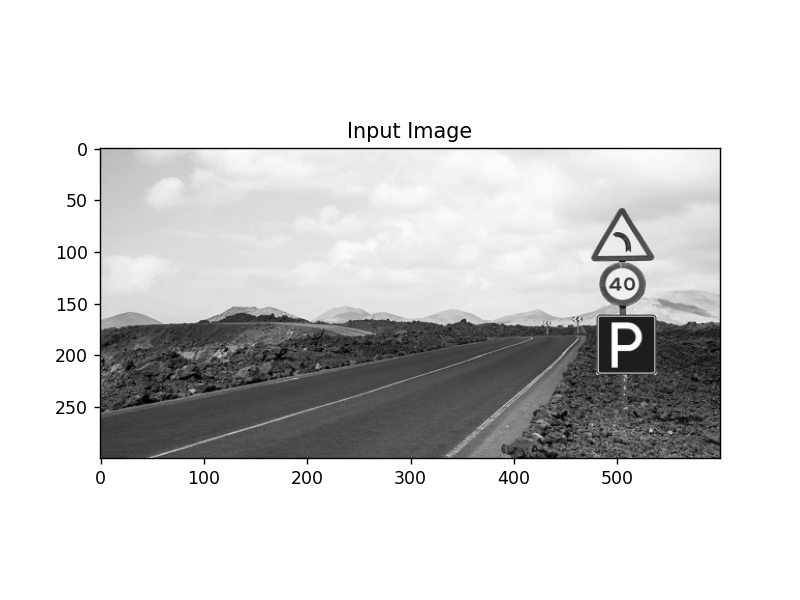

<IPython.core.display.Javascript object>


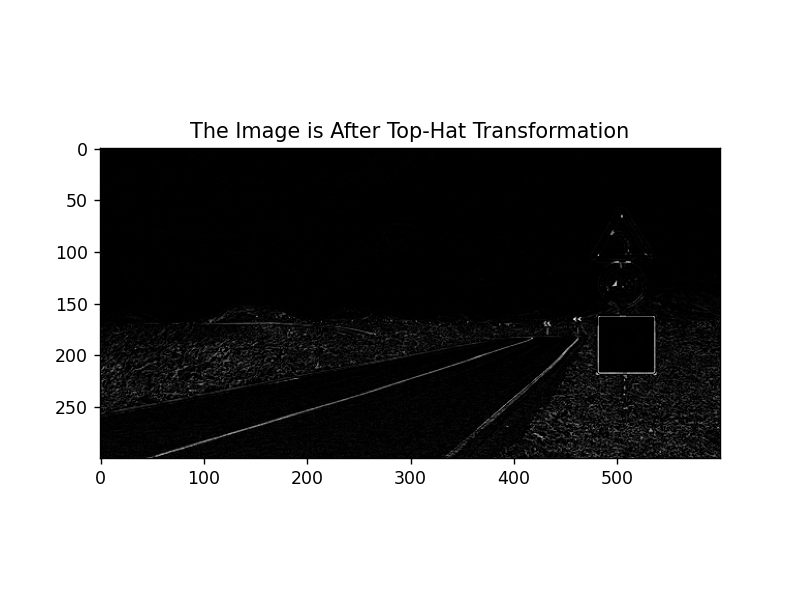

Otsu Threshold Value =  19.0


<IPython.core.display.Javascript object>


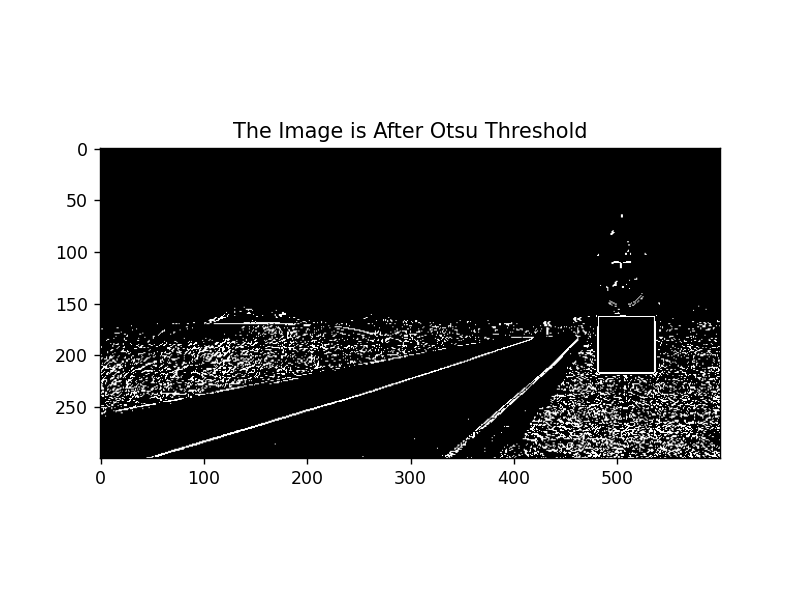

<IPython.core.display.Javascript object>


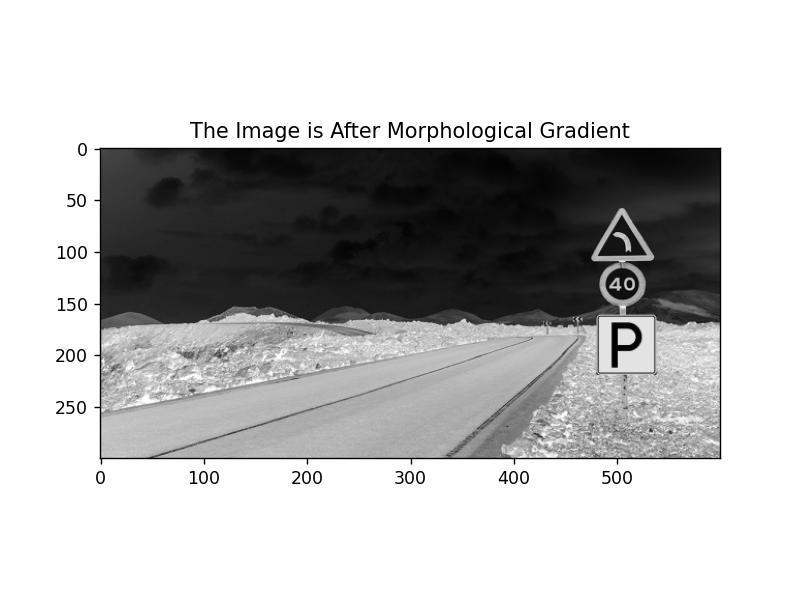

<IPython.core.display.Javascript object>


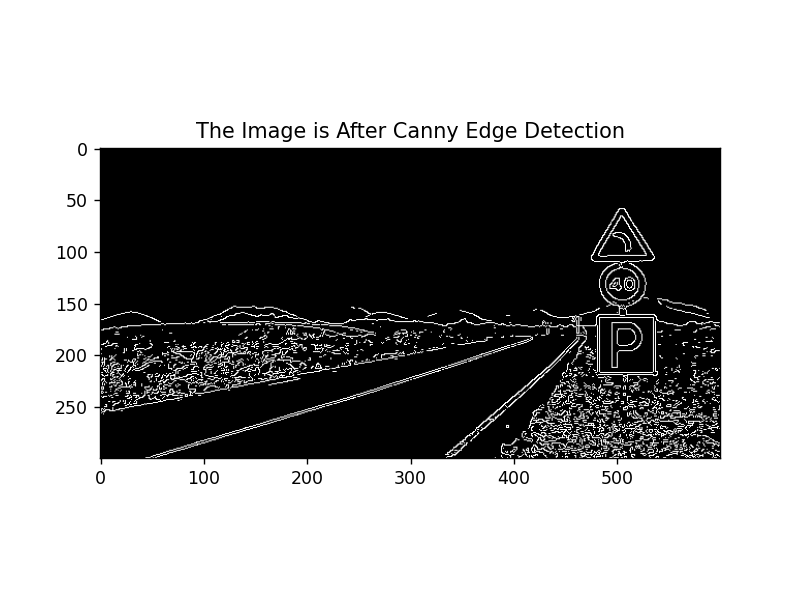

<IPython.core.display.Javascript object>


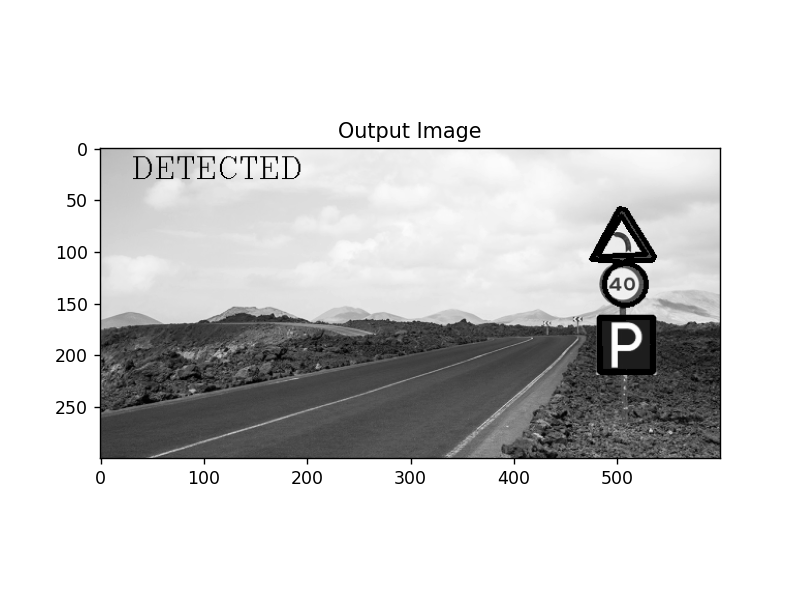

In [19]:
# Importing OpenCV and numpy
import cv2                                                 # OpenCv Library
from matplotlib import pyplot as plt                       # MatPlotLib Library
import numpy as np                                         # Numpy Library
import imutils                                             # For only resize operation
%matplotlib notebook 


def readInputImg():                                        # All images names are defined as "input_imageX".
                                                           # Just change the X value from 1 to 8
    # Reading the image named 'input_imageX.jpg'
    input_image = cv2.imread("input_image1.jpg")
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    
    # resized = imutils.resize(img, width=newwidth)
    input_image = imutils.resize(input_image,width=600 )   # The process of resizing the image
    
    # Thanks to this function, the width and length of the selected image are adjusted in proportion to the input image.
    # If the input image width is 1200 and the height is 600, the newly formed image dimensions will be 600,300.
    plt.figure()                                           # Open new figure
    plt.imshow(input_image,cmap="gray")                    # Show this input_image gray scale format
    plt.title("Input Image")                               # Heading on image
        
    return input_image                                     # Return input image after reading and resizing


def topHatTransform(img):                                  # Top-Hat Transformation is a transformation used in the 
                                                           # segmentation of gray-level images that explore objects 
                                                           # with different luminous levels from the background
                                                           # TopHat[A,B] = A - (AoB)   or  TopHat[A,B] = (A•B)-A 
    filterSize =(3, 3) 
    
    # cv.getStructuringElement (shape, ksize, anchor = new cv.Point(-1, -1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, filterSize)
    
    # The kernel will create a square building element with a size of 3x3.
    # Applying the Top-Hat operation
    # cv.morphologyEx(input_image, morphological transformations name, kernel)
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)

    plt.figure()                                            # Open new figure
    plt.imshow(tophat,cmap='gray')                          # Show this image gray scale format
    plt.title("The Image is After Top-Hat Transformation")  # Heading on image
    
    return tophat                                           # Return the image after the top-hat transformation 


def thresholdOfOtsu(img):                                   # The Otsu method allows to determine the optimal threshold 
                                                            # value that can be used when reducing a gray-level image
                                                            # to a binary level
    thresholdValue,thresholdedImg = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Otsu Threshold
    
    # ret,th = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    print("Otsu Threshold Value = ",thresholdValue)         # Otsu Threshold Value
    
    plt.figure()                                            # Open new figure
    plt.imshow(thresholdedImg,cmap='gray')                  # Show this image gray scale format
    plt.title("The Image is After Otsu Threshold")          # Heading on image
    
    return thresholdedImg                                   # Return the image after the otsu thresholding


def morphologicGradient(img,input_image):                   # Gradient(f) = (A⊕B) - (A⊖B)  
                                                            # The morphological Gradient is found by 
                                                            # subtract the dilation and erosion of an image     
    
    # cv.getStructuringElement (shape, ksize, anchor = new cv.Point(-1, -1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)) # The kernel will create a square building element with a 
                                                             # size of 3x3.
        
    # The first parameter is the original image, kernel is the matrix with which image is
    # convolved and third parameter is the number of iterations, which will determine how much
    erosion = cv2.erode(img, kernel, iterations = 1)
    dilation = cv2.dilate(img, kernel, iterations=1)
    gradient = dilation - erosion                            # The morphological Gradient is found by subtract the
    new_grad = gradient - input_image                        # dilation and erosion of an imagefor more thin edge on image
        
    plt.figure()                                             # Open new figure
    plt.imshow(new_grad,cmap='gray')                         # Show this image gray scale format
    plt.title('The Image is After Morphological Gradient')   # Heading on image
    
    return new_grad                                          # Return the image after morphological gradient


def cannyEdge(img):                                          # The Canny edge detector is an edge detection operator
                                                             # that uses a multi-stage algorithm to detect 
                                                             # a wide range of edges in images.
            
    # cv2.Canny(image, threshold1, threshold2, apertureSize, L2gradient)
    # Threshold1: It is the High threshold value of intensity gradient (double)
    # Threshold2: It is the Low threshold valueof intensity gradient.(double)        
    edgedImg = cv2.Canny(img, 170, 200)
    
    plt.figure()                                             # Open new figure
    plt.imshow(edgedImg,cmap='gray')                         # Show this image gray scale format
    plt.title("The Image is After Canny Edge Detection")     # Heading on image
    
    return edgedImg                                          # Return the image after canny edge


def findTrafficSign(img,input_image):
    
    # Initialize the shape contours
    triangularCnt = None 
    squareCnt = None
    hexagonCnt = None
    octagonalCnt = None
    
    ######################################################################################################################
    #          TRİANGULAR OR INVERTED TRIANGLE -- SQUARE, RHOMBUS OR RECTANGULAR -- HEXAGON -- OCTAGONAL                 #
    ######################################################################################################################
    
    # Contours are defined as the line connecting all points along the border of an image of the same density.

    # cv2.RETR_LIST = This is the simplest of the four flags (from explanation point of view). 
    # It simply retrieves all the contours, but doesn't create any parent-child relationship. 
    # Parents and kids are equal under this rule, and they are just contours. ie they all belongs to same hierarchy level.
    # CHAIN_APPROX_SIMPLE = algorithm compresses horizontal, vertical, and diagonal segments along the contour and leaves 
    # only their end points.
    
    # cnts,new = cv2.findContours(src, contour_retrieval, contours_approximation)
    # all contour values are stored in the cnts variable
    cnts, new  = cv2.findContours(img.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # sorted func, sort contours based on their area keeping minimum required
    # area as 6 (anything smaller than this willnot be considered)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:6]
    
    # Loop over our contours to find the best possible approximate contour of triangular traffic sign
    for c in cnts:
        # cv2.arcLength() is used to calculate the perimeter of the contour.
        # If the second argument is true then it considers the contour to be closed.
        perimeterCnt = cv2.arcLength(c, True)                 
        epsilon = 0.01 * perimeterCnt
        
        # cv2.approxPolyDP() function with a precision factor for approximating a shape. If the contour is a curve, 
        # it is different, and if it is a closed shape, the values it returns are different.
        approximations  = cv2.approxPolyDP(c, epsilon , True) 
        
        ########### ----- FOR TRIANGLE OR INVERTED TRIANGLE TRAFFİC SİGN ----- ########
        # len(approximations) as an number of edges. the triangle has 3 sides but the reason we wrote 4 is because of 
        # the poor quality of the images, it can detect that the triangle shapes have 4 edges than the guard was taken 
        if len(approximations) == 3 or len(approximations) == 4:
            
            triangularCnt = approximations                       #This is our approximation is a triangular shape
            # Its first argument is source image, second argument is the contours which should be passed as a Python list, 
            # third argument is index of contours, the fourth argument is color, and the fifth is thickness
            cv2.drawContours(input_image, [triangularCnt], 0, (0,255,0), 3)
        
        ############# ----- FOR SQUARE OR RHOMBUS TRAFFİC SİGN ----- ###################
        # len(approximations) as an number of edges. The square has 4 sides but because
        # it also captures very small frames in some images, its area is set to 20
        if (len(approximations) == 4) & (cv2.contourArea(c)>20): 
            
            squareCnt = approximations                            #This is our approximation is a square shape
            # Its first argument is source image, second argument is the contours which should be passed as a Python list, 
            # third argument is index of contours, the fourth argument is color, and the fifth is thickness
            cv2.drawContours(input_image, [squareCnt], 0, (0,255,0), 3)
        
        ################### ----- FOR HEXAGON TRAFFİC SİGN ----- ########################
        if (len(approximations) == 6): 
            
            hexagonCnt = approximations                           #This is our approximation is a hexagon shape
            # Its first argument is source image, second argument is the contours which should be passed as a Python list, 
            # third argument is index of contours, the fourth argument is color, and the fifth is thickness
            cv2.drawContours(input_image, [hexagonCnt], 0, (0,255,0), 3)
        
        ################## ----- FOR OCTOGONAL TRAFFİC SİGN ----- #######################
        if (len(approximations) == 8): 
            octagonalCnt = approximations                         #This is our approximation is a octagonal shape
            # Its first argument is source image, second argument is the contours which should be passed as a Python list, 
            # third argument is index of contours, the fourth argument is color, and the fifth is thickness
            cv2.drawContours(input_image, [octagonalCnt], 0, (0,255,0), 3)
        
    
    ####################################################################################################################
    #                             THE ALGORİTHM THAT FİNDS ONLY CİRCLE TRAFFİC SİGNS                                   #
    ####################################################################################################################
    
    # Apply Gaussian Blur for 3x3 kernel size
    gray = cv2.GaussianBlur(img,(3,3),0)                      
    
    # gray.shape has (max(x),max(y)) and max(x) is row size and max(y) is column size had already made 600.
    rows = gray.shape[0]
    
    # cv.HoughCircles (image, method, dp, minDist, param1, param2, minRadius, maxRadius)
    # dp, inverse ratio of the accumulator resolution to the image resolution
    # minimum distance, between the centers of the detected circles. 
    # param1, In case of HOUGH_GRADIENT , it is the higher threshold of the two passed to the Canny edge detector
    # param2, In case of HOUGH_GRADIENT , it is the accumulator threshold for the circle centers at the detection stage. 
    # minRadius, minimum circle radius.
    # maxRadius, maximum circle radius.
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, rows / 8,
                               param1=100, param2=65,
                               minRadius=0, maxRadius=60)
    
    if circles is not None:                                       # Guard block
        circles = np.uint16(np.around(circles))                   # np.around() converts the float to an integer by rounding
        
        for i in circles[0, :]:                                   # to print elements from specific Index until the end use [Index:]
            # Circles has a three elements
            center_coordinates = (i[0], i[1])                     # center_coordinates  = takes the first two elements of the circles
            radius = i[2]                                         # radius  = takes the last elements of the circles
            # cv2.circle(image, center_coordinates, radius, color, thickness)
            cv2.circle(input_image, center_coordinates, radius, (0,0,255), 3)
        
    cv2.putText(input_image, "DETECTED", (30, 30), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0))
    output_image = input_image
    plt.figure()
    plt.imshow(output_image,cmap="gray")
    plt.title("Output Image")
    
    # cv2.imwrite("test_output_image4.jpg",output_image)

def main():
    
    input_image = readInputImg()
    tophat = topHatTransform(input_image)
    otsuResultImg = thresholdOfOtsu(tophat)
    morphGradResult = morphologicGradient(otsuResultImg,input_image)
    cannyResult = cannyEdge(morphGradResult)
    findTrafficSign(cannyResult,input_image)

main()